In [1]:
%matplotlib inline 

In [2]:
import os
import json
import re 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize

In [3]:
def CustomParser(data):
    return json.loads(data)


FOLDER = '../results/'
regex = re.compile(r'.csv')
folders = set(os.listdir(FOLDER))
folders = filter(lambda i: regex.search(i), folders)
folders = [i for i in folders if regex.search(i)]

df = pd.DataFrame()
# Read csv file
for filename in folders:
    ddf = pd.read_csv(FOLDER + filename, sep=';', converters={'db_parameters': CustomParser, 'model_cfg': CustomParser})
    ddf[sorted(ddf['db_parameters'][0].keys())] = ddf['db_parameters'].apply(pd.Series)
    ddf[sorted(ddf['model_cfg'][0].keys())] = ddf['model_cfg'].apply(pd.Series)
    
    df = pd.concat([df, ddf])

In [4]:
df.shape

(434, 12)

In [5]:
folders = set(os.listdir(FOLDER))

regex = re.compile(r'.csv')
# use only one of the following lines, whichever you prefer
folders = filter(lambda i: not regex.search(i), folders)
folders = [i for i in folders if not regex.search(i)]

folders.remove('_sources')
folders.remove('results.tar.gz')
folders.remove('r.zip')

result = {
    'acc': [],
    'f1': [],
    'db': [],
    'task': [],
    'model': [],
    'db_parameters': []
}

folders

['model_cfg.model=pypagai.models.model_n2nmemory.N2NMemory',
 'rn',
 'model_default_cfg.model=pypagai.models.model_dmn.DMN',
 'model_default_cfg.model=qa.models.model_rn.ConvQueryRN',
 'model_cfg.model=pypagai.models.model_encoder.EncoderModel_2',
 'model_default_cfg.model=qa.models.model_rn.RNNoLSTM',
 'model_cfg.model=pypagai.models.model_encoder.EncoderModel',
 'rf',
 'model_default_cfg.model=pypagai.models.model_rnn.RNNModel',
 'model_cfg.model=pypagai.models.model_rn.RN_2',
 'model_cfg.model=pypagai.models.model_embed_lstm.EmbedLSTM',
 'model_default_cfg.model=qa.models.model_rn.ConvInputsRN',
 'model_default_cfg.model=pypagai.models.model_n2nmemory.N2NMemory',
 'model_cfg.model=pypagai.models.model_lstm.EmbedLSTM',
 'model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM',
 'model_cfg.model=pypagai.models.model_rn.RN',
 'model_cfg.model=pypagai.models.model_lstm.SimpleLSTM',
 'model_default_cfg.model=qa.models.model_rn.ConvRN',
 'model_cfg.model=pypagai.models.model_n2nmemor

In [6]:
folders = set(os.listdir(FOLDER))

regex = re.compile(r'.csv')
# use only one of the following lines, whichever you prefer
folders = filter(lambda i: not regex.search(i), folders)
folders = [i for i in folders if not regex.search(i)]

folders.remove('_sources')
folders.remove('results.tar.gz')
folders.remove('r.zip')

result = {
    'acc': [],
    'f1': [],
    'db': [],
    'task': [],
    'model': [],
    'db_parameters': []
}

for root_folder in folders:
    for run_id in os.listdir(FOLDER + root_folder):
        current_folder = FOLDER + root_folder + '/' + run_id

        metrics_file = current_folder + '/metrics-test.csv'
        config_file = current_folder + '/config.json'

        if not os.path.exists(metrics_file) or not os.path.exists(config_file):
            continue

        config_df = pd.read_json(config_file)
        if config_df['dataset_cfg']['reader'] != "pypagai.preprocessing.dataset_babi.BaBIDataset":
            continue

        db = 'babi'

        task = config_df['dataset_cfg']['task']
        model = config_df['model_default_cfg']['model'].split('.')[-1]
        
        metrics_df = pd.read_csv(metrics_file)
        acc = metrics_df['accuracy'][0]
        f1 = metrics_df['f1_micro'][0]

        result['f1'].append(f1)
        result['db'].append(db)
        result['acc'].append(acc)
        result['task'].append(task)
        result['model'].append(model)
        result['db_parameters'].append(config_file)

new_results = pd.DataFrame(result)
df = pd.concat([df, new_results])

model,ConvInputsRN,ConvQueryRN,ConvRN,ConvStoryRN,DeepN2NMemory,EmbedLSTM,EncoderModel,N2NMemory,RN,RNNModel,RNNoLSTM,SimpleLSTM
task,,,,,,,,,,,,
1,0.456,0.477,0.157,0.911,0.963,0.979,0.349,0.953,0.367,1.000,0.813,0.504
2,0.354,NaN,NaN,NaN,0.325,0.445,0.370,0.281,NaN,0.439,NaN,0.190
3,NaN,NaN,NaN,NaN,0.251,0.534,0.310,0.242,NaN,0.387,NaN,0.207
4,NaN,NaN,NaN,NaN,1.000,1.000,0.572,1.000,1.000,0.997,NaN,0.279
5,NaN,NaN,NaN,NaN,0.826,0.990,0.313,0.869,NaN,0.990,NaN,0.344
6,NaN,NaN,NaN,0.497,0.972,0.679,0.527,0.995,0.822,0.497,NaN,0.636
7,NaN,NaN,NaN,NaN,0.904,NaN,0.764,0.879,NaN,0.998,NaN,0.693
8,NaN,NaN,NaN,NaN,0.802,NaN,0.740,0.804,NaN,0.995,NaN,0.539
9,NaN,NaN,NaN,NaN,0.962,NaN,0.585,0.959,0.829,1.000,0.827,0.655


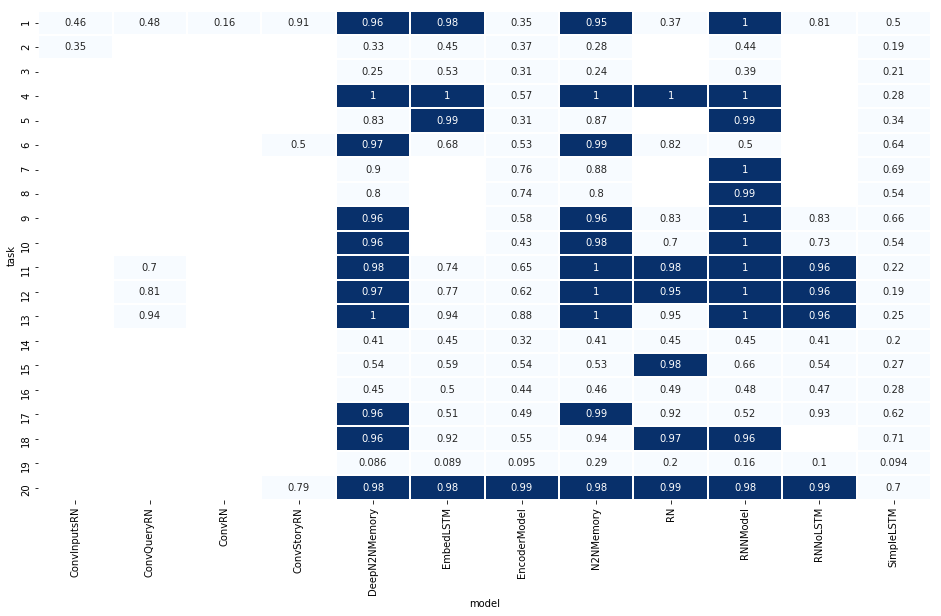

In [7]:
# Show best result of each model for each babi task
# model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN','EmbedLSTM','EncoderModel','RNNModel','RNNoLSTM','SimpleLSTM']

ddf = df[df['db'] == 'babi']
# ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)
pivot

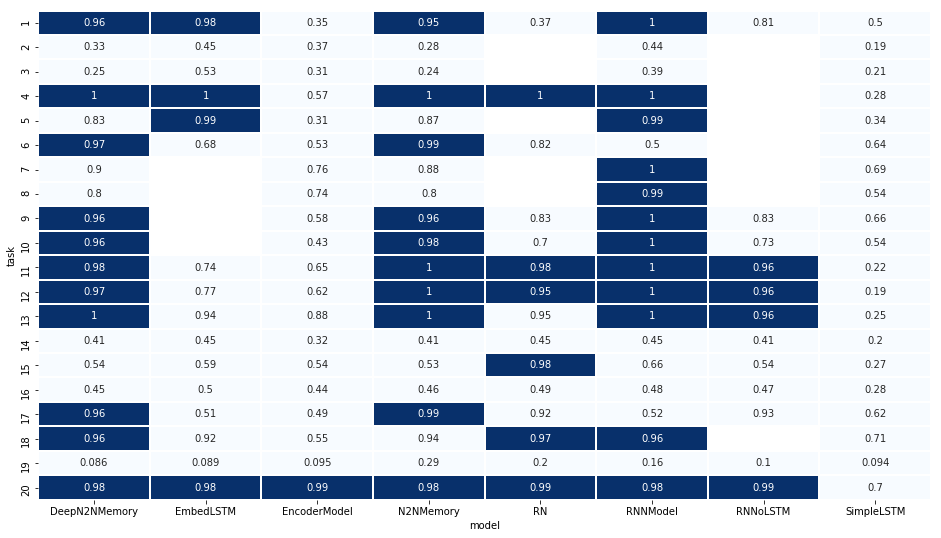

In [8]:
# Show best result of each model for each babi task
model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN',]

ddf = df[df['db'] == 'babi']
ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)